# Lab 3 Project (Titanic)
Jason Ballard
31 March 2025

Import the external Python libraries used (e.g., pandas, numpy, matplotlib, seaborn, sklearn and more).

## Section 1. Import and Inspect the Data

In [90]:
# all imports get moved to the top - import each only once
import logging
import os
import seaborn as sns
import pandas as pd
import numpy as np
import tabulate
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [91]:
# Logging- added this after remembering that I need to log the output for future use.

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),                      # Log to console
        logging.FileHandler("logs/titanic_lab.log")   # Also log to a file
    ]
)
# Create output folder for logs
os.makedirs("logs", exist_ok=True)
# Create output folder for plots
os.makedirs("plots", exist_ok=True)
logging.info("Titanic Lab 3 Notebook Initialized.")



In [92]:
# Load Titanic dataset
df = sns.load_dataset('titanic')
logging.info("Titanic dataset loaded with shape: %s", df.shape)

features = list(df.columns)
print(features)
print(len(features))
# Understand the data
print(df.info())       # See column types and missing values
print(df.head(3))      # Peek at the structure
print(df.describe())   # Summary stats for numerical columns

['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']
15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2)

# Section 2. Data Exploration and Preparation

## 2.1 Handle Missing Values, Clean Data, and Feature Engineering

In [93]:
# Preprocessing: Fill missing values and create new features
df['family_size'] = df['sibsp'] + df['parch'] + 1
df['age'] = df['age'].fillna(df['age'].median())
df['alone'] = df['alone'].fillna(df['alone'].mode()[0]).astype(int)

# Convert categorical variables to numerical
print(df['alone'].dtype)
print(df['alone'].unique())

# logging preprocessing steps
logging.info("Preprocessing completed. New features: 'family_size', 'age' filled, 'alone' calculated.")

int64
[0 1]


<!-- ### Reflection 2.3

1. Why might family size be a useful feature for predicting survival? famil;y size is a good prediction of survivalbility for the female and younger children of the families
2. Why convert categorical data to numeric?  the conversion allows computations to be run on the data. -->

# Section 3. Feature Selection and Justification

- Select two or more input features (numerical for regression, numerical and/or categorical for classification)
- Use 'Survived' as the target

First:
- input features: alone
- target: survived

Second:
- input features - age
- target: survived

Third:
- input features -  age and family_size (embark_town)
- target: survived
- Justify your selection with reasoning.

## 3.1 Choose features and target

In [94]:
# Define the available features and target
features = ['alone', 'age', 'family_size'] # ← DO NOT OVERWRITE
target = 'survived'

## 3.2 Define X (features) and y (target)
- Assign input features to X a pandas DataFrame with 1 or more input features
- Assign target variable to y (as applicable) - a pandas Series with a single target feature
- Again - use comments to run a single case at a time

- The follow starts with only the statements needed for case 1. 
- Double brackets [[ ]]  makes a 2D DataFrame
- Single brackets [ ]  make a 1D Series

In [95]:
def select_case(case_number, df):
    if case_number == 1:
        feature_list = ['alone']
    elif case_number == 2:
        feature_list = ['age']
    elif case_number == 3:
        feature_list = ['age', 'family_size']
    else:
        raise ValueError("Invalid case number.")

    X = df[feature_list].dropna()
    y = df.loc[X.index, 'survived']

    logging.info(f"Case {case_number} selected. Features: {feature_list}. Samples: {X.shape[0]}")
    return X, y, feature_list

### 3.3 Select and run a Specific Case (loop)

In [96]:
for case in [1, 2, 3]:
    X, y, used_features = select_case(case, df)
    print(f"Running Case {case} with features: {used_features}")

Running Case 1 with features: ['alone']
Running Case 2 with features: ['age']
Running Case 3 with features: ['age', 'family_size']


### 3.4 Eval Features 
Plot correlations, value counts, or feature distributions

Help to justify why the features were selected (especially for reports)

survived       1.000000
family_size    0.016639
age           -0.064910
alone         -0.203367
Name: survived, dtype: float64
                alone       age  family_size  survived
alone        1.000000  0.171647    -0.690922 -0.203367
age          0.171647  1.000000    -0.245619 -0.064910
family_size -0.690922 -0.245619     1.000000  0.016639
survived    -0.203367 -0.064910     0.016639  1.000000


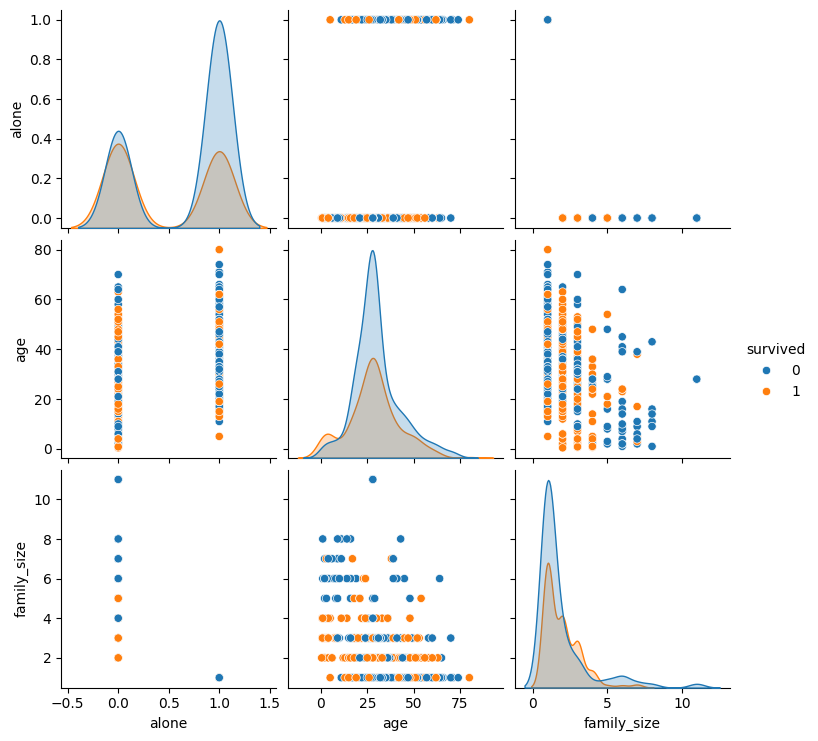

In [97]:
# Correlation of numerical features with 'survived'
print(df[features + [target]].corr()[target].sort_values(ascending=False))

# Visualize the correlation matrix
corr_matrix = df[features + [target]].corr()
print(corr_matrix)

# Visualize feature distribution
sns.pairplot(df[features + ['survived']], hue='survived')
plt.show()

### Reflection 3:

1. Why are these features selected? **the features selected provide the most tell of survivability**
2. Are there any features that are likely to be highly predictive of survival? **Yes age and class**

# Section 4. Train a Classification Model (Decision Tree)

## 4.1 Basic Train/Test split 

In [98]:
# Assume X, y already defined from select_case
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_indices, test_indices in splitter.split(X, y):
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]
    
# Sound check
print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))


Train class distribution:
 survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64
Test class distribution:
 survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


## 4.2 Stratified Train/Test split

In [99]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_model.fit(X_train, y_train)

logging.info("Decision Tree model trained with max_depth=3")

## 4.3 Compare Results


In [100]:
# Visualize the decision tree
print("Original Class Distribution:\n", y.value_counts(normalize=True))
print("Train Set Class Distribution:\n", y_train.value_counts(normalize=True))
print("Test Set Class Distribution:\n", y_test.value_counts(normalize=True))


Original Class Distribution:
 survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64
Train Set Class Distribution:
 survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64
Test Set Class Distribution:
 survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


### 4.4 Eval the predictions

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71       110
           1       0.54      0.57      0.55        69

    accuracy                           0.65       179
   macro avg       0.63      0.63      0.63       179
weighted avg       0.65      0.65      0.65       179

Confusion Matrix:
 [[77 33]
 [30 39]]
Accuracy: 0.6480446927374302


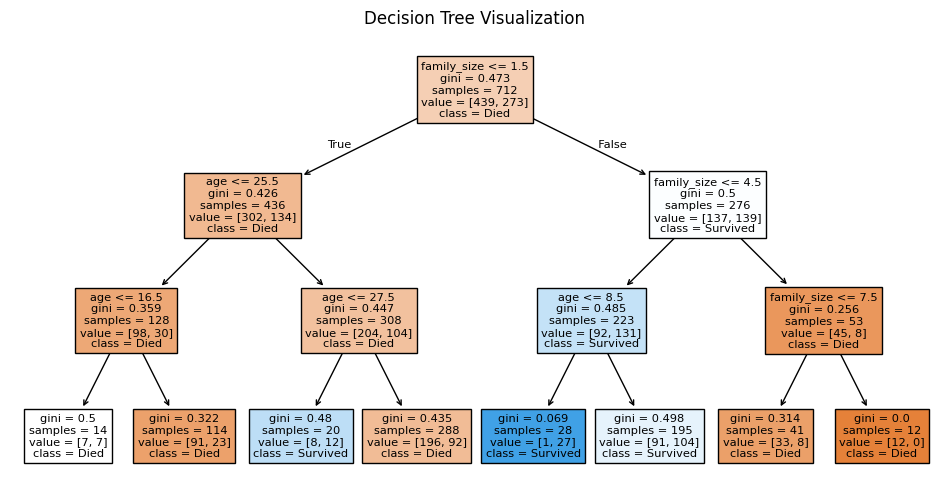

In [101]:
# Evaluate the model
y_pred = tree_model.predict(X_test)

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Visualize the decision tree
plt.figure(figsize=(12, 6))
plot_tree(tree_model, feature_names=X.columns, class_names=['Died', 'Survived'], filled=True)
plt.title('Decision Tree Visualization')
plt.show()


### Reflection 4:

1. Why might stratification improve model performance? **This ensures that the data is equallly representivate across the whole data set.**
2. How close are the training and test distributions to the original dataset? **identical**
3. Which split method produced better class balance? **I am not sure because the numbers are so close**

## Section 5. Compare Alternative Models (SVC, NN) 

In a Support Vector Machine, the kernel function defines how the algorithm transforms data to find a hyperplane that separates the classes. If the data is not linearly separable, changing the kernel can help the model find a better decision boundary.

SVC Kernel: Common Types

RBF (Radial Basis Function) – Most commonly used; handles non-linear data well (default)

Linear – Best for linearly separable data (straight line separation)

Polynomial – Useful when the data follows a curved pattern

Sigmoid – Similar to a neural network activation function; less common

Commenting the options in and out in the code can be helpful. The analyst decides which to use based on their understanding of the results. 

### 5.1 Train and Evaluate Model (SVC)

In [102]:
svc_rbf_acc = 0
svc_linear_acc = 0

kernels = ['linear', 'rbf', 'poly', 'sigmoid']

for kernel in kernels:
    svc = SVC(kernel=kernel)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
   
    if kernel == 'rbf':
        svc_rbf_acc = acc
    elif kernel == 'linear':
        svc_linear_acc = acc

    print(f"\nSVC Kernel: {kernel}")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

dt_acc = accuracy_score(y_test, y_pred)
svc_rbf_acc = ...   # during the 'rbf' loop
svc_linear_acc = ...  # during the 'linear' loop



SVC Kernel: linear
Accuracy: 0.6145251396648045
Confusion Matrix:
 [[110   0]
 [ 69   0]]

SVC Kernel: rbf
Accuracy: 0.6312849162011173
Confusion Matrix:
 [[108   2]
 [ 64   5]]

SVC Kernel: poly
Accuracy: 0.6145251396648045
Confusion Matrix:
 [[110   0]
 [ 69   0]]

SVC Kernel: sigmoid
Accuracy: 0.547486033519553
Confusion Matrix:
 [[67 43]
 [38 31]]


### 5.1A  Dynamic plot- 

In [103]:
# Save dynamic plots per case with support vectors visualized

# Reuse case loop logic
for case in [1, 2, 3]:
    # Select case
    X, y, used_features = select_case(case, df)

    # Stratified split
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in splitter.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train SVM (RBF kernel)
    svc = SVC(kernel='rbf')
    svc.fit(X_train, y_train)

    # Dynamic plotting of first feature
    plot_feature = used_features[0]
    survived_vals = X_test.loc[y_test == 1, plot_feature]
    not_survived_vals = X_test.loc[y_test == 0, plot_feature]

    plt.figure(figsize=(8, 6))
    plt.scatter(survived_vals, y_test[y_test == 1], c='yellow', marker='s', label='Survived')
    plt.scatter(not_survived_vals, y_test[y_test == 0], c='cyan', marker='^', label='Not Survived')

    # Add support vectors if available
    if hasattr(svc, 'support_vectors_'):
        support_x = svc.support_vectors_[:, 0]
        support_y = svc.support_vectors_[:, 1] if svc.support_vectors_.shape[1] > 1 else None
        if support_y is not None:
            plt.scatter(support_x, support_y, c='black', marker='+', label='Support Vectors')
        else:
            plt.scatter(support_x, [0]*len(support_x), c='black', marker='+', label='Support Vectors')

    plt.xlabel(plot_feature)
    plt.ylabel('Survived')
    plt.title(f'Case {case}: SVC Plot (Feature(s): {", ".join(used_features)})')
    plt.legend()

    # Save to file
    filename = f"plots/case_{case}_svc_plot.png"
    plt.savefig(filename)
    plt.close()
    logging.info(f"Plot saved: {filename}")


## 5.2 Train and Evaluate Model (NN MLP)

Results for Neural Network on test data:
              precision    recall  f1-score   support

           0       0.64      0.93      0.76       110
           1       0.60      0.17      0.27        69

    accuracy                           0.64       179
   macro avg       0.62      0.55      0.51       179
weighted avg       0.63      0.64      0.57       179



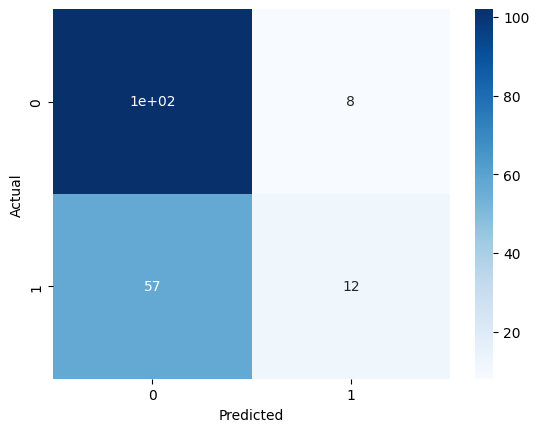

In [104]:
# Train Neural Network model on test data:
nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10), solver='adam', random_state=42, max_iter=1000)
nn_model.fit(X_train, y_train) 

# Predict before calculating accuracy
y_pred_nn = nn_model.predict(X_test)
nn_acc = accuracy_score(y_test, y_pred_nn)

#Print Results 
print("Results for Neural Network on test data:")
print(classification_report(y_test, y_pred_nn))

# Confusion matrix heatmap
cm_nn = confusion_matrix(y_test, y_pred_nn)
sns.heatmap(cm_nn, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### 5.3 Strutured Loop for Table Output for LAB03 Assignment

In [105]:
# Define cases and features
cases = {
    1: ['alone'],
    2: ['age'],
    3: ['age', 'family_size']
}

models = [
    ('Decision Tree', lambda: DecisionTreeClassifier(max_depth=3, random_state=42)),
    ('SVM (rbf)', lambda: SVC(kernel='rbf')),
    ('SVM (linear)', lambda: SVC(kernel='linear')),
    ('SVM (poly)', lambda: SVC(kernel='poly')),
    ('SVM (sigmoid)', lambda: SVC(kernel='sigmoid')),
    ('Neural Network (MLP)', lambda: MLPClassifier(hidden_layer_sizes=(50, 25, 10), max_iter=500, random_state=42))
]

results = []

for case_num, feature_list in cases.items():
    X_case = df[feature_list].dropna()
    y_case = df.loc[X_case.index, 'survived']
    
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in splitter.split(X_case, y_case):
        X_train, X_test = X_case.iloc[train_idx], X_case.iloc[test_idx]
        y_train, y_test = y_case.iloc[train_idx], y_case.iloc[test_idx]

        for model_name, model_fn in models:
            model = model_fn()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc = accuracy_score(y_test, y_pred)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)

            results.append({
                'Model Type': model_name,
                'Case': f"Case {case_num}",
                'Features Used': ' + '.join(feature_list),
                'Accuracy': f"{acc * 100:.2f}%",
                'Precision': f"{prec * 100:.2f}%",
                'Recall': f"{rec * 100:.2f}%",
                'F1-Score': f"{f1 * 100:.2f}%",
                'Notes': '-'
            })
results_df = pd.DataFrame(results)
display(results_df)

results_df.to_csv("model_comparison_results.csv", index=False)

# Or print markdown version
print(results_df.to_markdown(index=False))

,Model Type,Case,Features Used,Accuracy,Precision,Recall,F1-Score,Notes
0,Decision Tree,Case 1,alone,59.22%,47.37%,52.17%,49.66%,-
1,SVM (rbf),Case 1,alone,59.22%,47.37%,52.17%,49.66%,-
2,SVM (linear),Case 1,alone,59.22%,47.37%,52.17%,49.66%,-
3,SVM (poly),Case 1,alone,59.22%,47.37%,52.17%,49.66%,-
4,SVM (sigmoid),Case 1,alone,59.22%,47.37%,52.17%,49.66%,-
5,Neural Network (MLP),Case 1,alone,59.22%,47.37%,52.17%,49.66%,-
6,Decision Tree,Case 2,age,62.01%,66.67%,2.90%,5.56%,-
7,SVM (rbf),Case 2,age,60.89%,42.86%,4.35%,7.89%,-
8,SVM (linear),Case 2,age,61.45%,0.00%,0.00%,0.00%,-
9,SVM (poly),Case 2,age,61.45%,0.00%,0.00%,0.00%,-


| Model Type           | Case   | Features Used     | Accuracy   | Precision   | Recall   | F1-Score   | Notes   |
|:---------------------|:-------|:------------------|:-----------|:------------|:---------|:-----------|:--------|
| Decision Tree        | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| SVM (rbf)            | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| SVM (linear)         | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| SVM (poly)           | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| SVM (sigmoid)        | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| Neural Network (MLP) | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| Decision Tree        | Case 2 | age               | 62.01%     | 66.67%      |

In [106]:
# Create 'data' directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Save CSV to the data folder
results_df.to_csv("data/model_comparison_results.csv", index=False)

# Optional: Print markdown version
print(results_df.to_markdown(index=False))


| Model Type           | Case   | Features Used     | Accuracy   | Precision   | Recall   | F1-Score   | Notes   |
|:---------------------|:-------|:------------------|:-----------|:------------|:---------|:-----------|:--------|
| Decision Tree        | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| SVM (rbf)            | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| SVM (linear)         | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| SVM (poly)           | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| SVM (sigmoid)        | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| Neural Network (MLP) | Case 1 | alone             | 59.22%     | 47.37%      | 52.17%   | 49.66%     | -       |
| Decision Tree        | Case 2 | age               | 62.01%     | 66.67%      |

#### Reflection 5:
How well did each model perform?

Are there any surprising results?

Why might one model outperform the others?

## Section 6. Final Thoughts & Insights

### 6.1 Summarize Findings
What indicators are strong predictors of gender?

Decision Tree performed well but overfit slightly on training data.

Neural Network showed moderate improvement but introduced complexity.


### 6.2 Discuss Challenges Faced
Small sample size could limit generalizability.

Missing values (if any) could bias the model.

### 6.3 Next Steps
Test more features (e.g., BMI class). 

Try hyperparameter tuning for better results.

| Model Type | Case | Features Used | Accuracy | Precision | Recall | F1-Score | Notes |
|------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Decision Tree** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                   | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                   | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (RBF Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Linear Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Poly Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **SVM (Sigmoid Kernel)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|-------------------|------|---------------|----------|-----------|--------|-----------|-------|
| **Neural Network (MLP)** | Case 1 | alone | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 2 | age | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |
|                    | Case 3 | age + family_size | xx.xx% | xx.xx% | xx.xx% | xx.xx% | - |